In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adityarao2110
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:16<00:00, 25.4MB/s]


In [60]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [3]:
import torch
from torchvision import datasets, transforms


# Define a transformation to preprocess the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to a fixed size.
    transforms.CenterCrop((64,64)),
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor.
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image (-1 to 1).
])

dataset = datasets.ImageFolder('/content/animefacedataset', transform=transform)

In [4]:
from torch.utils.data import DataLoader
batch_size = 128
train_dl = DataLoader(dataset, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

In [63]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [5]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
stats[1][0]

0.5

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

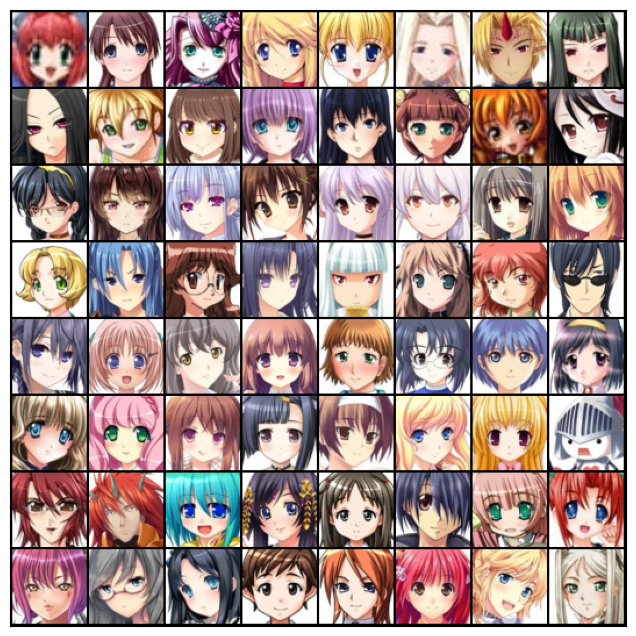

In [8]:
show_batch(train_dl)

In [9]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # in: 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Create an instance of the Discriminator
discriminator = Discriminator()


In [65]:
discriminator = to_device(discriminator, device)

In [10]:
import torch.nn as nn

latent_size = 128

class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # in: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

In [11]:
import torch

generator = Generator(latent_size)
batch_size = 128
# Generate random latent tensors
xb = torch.randn(batch_size, latent_size, 1, 1)

# Generate fake images using the generator instance
fake_images = generator(xb)

# Check the shape of the generated images
print(fake_images.shape)


torch.Size([128, 3, 64, 64])


In [66]:
generator = to_device(generator, device)

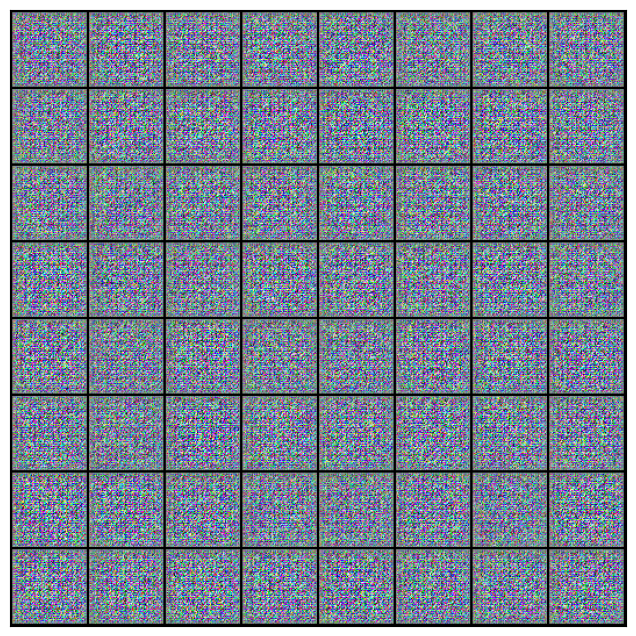

In [12]:
show_images(fake_images)

In [13]:
# Assuming dataset[0] returns a tuple (data, label)
data, label = dataset[0]

# Access the shape of the data tensor
data_shape = data.shape
print(data_shape)


torch.Size([3, 64, 64])


In [67]:
import torch.nn.functional as F

def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [68]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [16]:
from torchvision.utils import save_image

In [17]:
import os
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [69]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


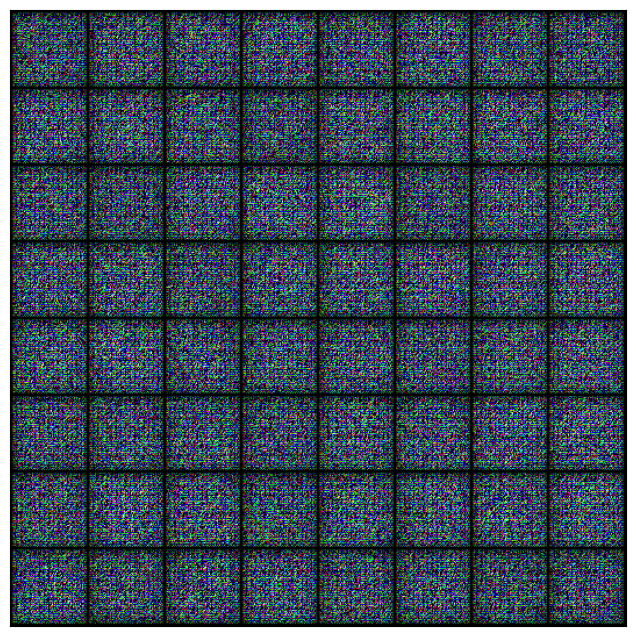

In [20]:
save_samples(0, fixed_latent)

In [52]:
from tqdm.notebook import tqdm
def fit(epochs, learning_rate, start_epoch=1):

    # Lists to store losses and scores
    generator_losses = []
    discriminator_losses = []
    real_scores_list = []
    fake_scores_list = []


    # Create optimizers for the discriminator and generator
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train the discriminator
            loss_discriminator, real_score, fake_score = train_discriminator(real_images, optimizer_discriminator)

            # Train the generator
            loss_generator = train_generator(optimizer_generator)

        # Record losses and scores
        generator_losses.append(loss_generator)
        discriminator_losses.append(loss_discriminator)
        real_scores_list.append(real_score)
        fake_scores_list.append(fake_score)

        # Log losses and scores (last batch)
        print("Epoch [{}/{}], Generator Loss: {:.4f}, Discriminator Loss: {:.4f}, Real Score: {:.4f}, Fake Score: {:.4f}".format(
            epoch + start_epoch, epochs + start_epoch - 1, loss_generator, loss_discriminator, real_score, fake_score))

        # Save generated images
        save_samples(epoch + start_epoch, fixed_latent, show=False)

    return generator_losses, discriminator_losses, real_scores_list, fake_scores_list


In [22]:
lr = 0.0002
epochs = 10

In [23]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10], Generator Loss: 5.6150, Discriminator Loss: 0.8130, Real Score: 0.5624, Fake Score: 0.0060
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], Generator Loss: 3.7573, Discriminator Loss: 0.1682, Real Score: 0.9193, Fake Score: 0.0702
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], Generator Loss: 7.7839, Discriminator Loss: 0.0931, Real Score: 0.9417, Fake Score: 0.0231
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], Generator Loss: 5.2780, Discriminator Loss: 0.1830, Real Score: 0.9273, Fake Score: 0.0940
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], Generator Loss: 5.3359, Discriminator Loss: 0.0214, Real Score: 0.9826, Fake Score: 0.0033
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], Generator Loss: 6.0804, Discriminator Loss: 0.2813, Real Score: 0.8033, Fake Score: 0.0024
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], Generator Loss: 5.3416, Discriminator Loss: 0.2798, Real Score: 0.8175, Fake Score: 0.0052
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], Generator Loss: 24.1753, Discriminator Loss: 1.8625, Real Score: 1.0000, Fake Score: 0.7234
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], Generator Loss: 7.7047, Discriminator Loss: 0.0224, Real Score: 0.9973, Fake Score: 0.0175
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10], Generator Loss: 9.0894, Discriminator Loss: 0.1814, Real Score: 0.8883, Fake Score: 0.0014
Saving generated-images-0010.png


In [24]:
losses_g, losses_d, real_scores, fake_scores = history

In [25]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [26]:
from IPython.display import Image

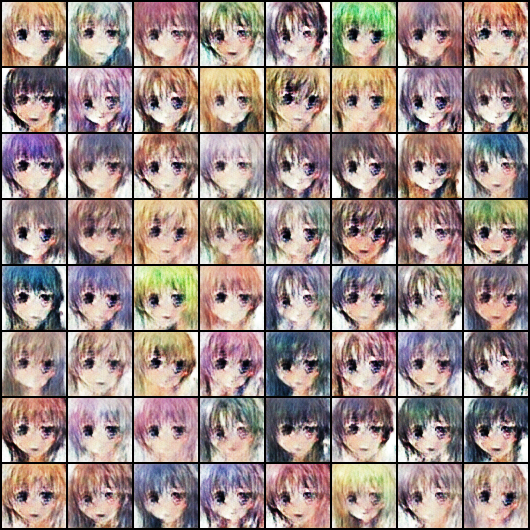

In [27]:
Image('./generated/generated-images-0005.png')

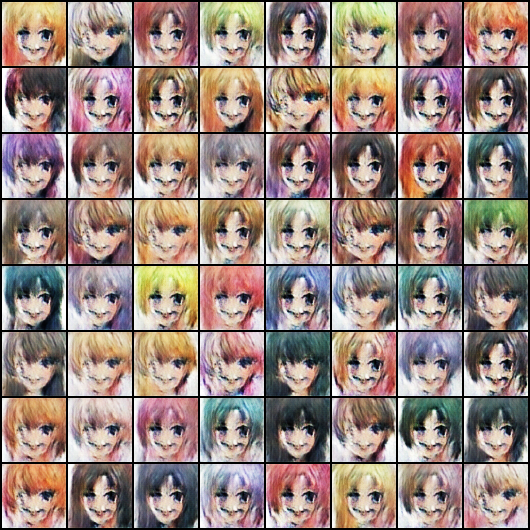

In [28]:
Image('./generated/generated-images-0010.png')

In [29]:
from google.colab import files
import cv2
import os

vid_fname = 'gans_training.avi'  # Output video file name

# Get a list of image files in the directory
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

# Check if there are any image files
if len(files) == 0:
    print("No image files found in the directory.")
else:
    # Open a video writer with the correct codec and frame rate
    out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))

    # Write each image to the video
    for fname in files:
        img = cv2.imread(fname)
        out.write(img)

    # Release the video writer
    out.release()
    print(f"Video '{vid_fname}' has been created successfully.")


Video 'gans_training.avi' has been created successfully.


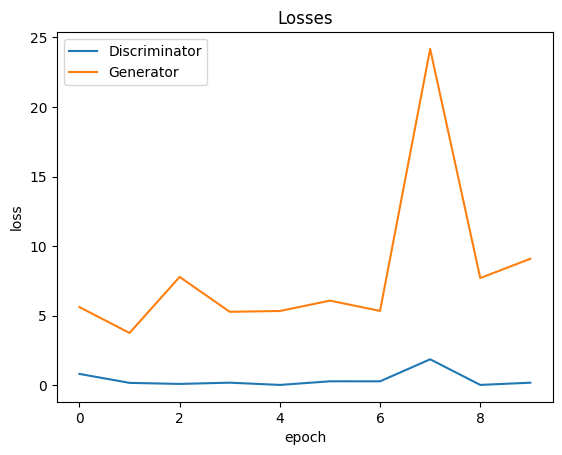

In [31]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

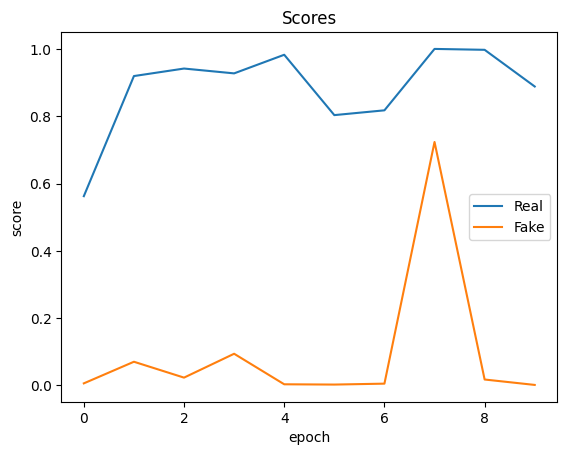

In [32]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [73]:
# Load the generator and discriminator models
generator_checkpoint = 'G.pth'
discriminator_checkpoint = 'D.pth'

# Create instances of the generator and discriminator models
generator = Generator(latent_size).to(device)  # Move to the selected device
discriminator = Discriminator().to(device)      # Move to the selected device

# Load the state dictionaries into the models on the correct device
generator.load_state_dict(torch.load(generator_checkpoint, map_location=device))
discriminator.load_state_dict(torch.load(discriminator_checkpoint, map_location=device))


<All keys matched successfully>

In [74]:
history = fit(epochs = 15, learning_rate = 0.0002, start_epoch=11)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], Generator Loss: 6.6687, Discriminator Loss: 0.0728, Real Score: 0.9713, Fake Score: 0.0374
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], Generator Loss: 7.9783, Discriminator Loss: 0.0439, Real Score: 0.9631, Fake Score: 0.0018
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], Generator Loss: 5.6970, Discriminator Loss: 0.0991, Real Score: 0.9404, Fake Score: 0.0221
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], Generator Loss: 15.6941, Discriminator Loss: 0.4053, Real Score: 0.9998, Fake Score: 0.2497
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], Generator Loss: 6.3447, Discriminator Loss: 0.0641, Real Score: 0.9647, Fake Score: 0.0165
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], Generator Loss: 21.9276, Discriminator Loss: 0.0846, Real Score: 0.9286, Fake Score: 0.0000
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], Generator Loss: 6.5724, Discriminator Loss: 0.0863, Real Score: 0.9625, Fake Score: 0.0436
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], Generator Loss: 8.2416, Discriminator Loss: 0.0552, Real Score: 0.9705, Fake Score: 0.0131
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], Generator Loss: 6.6858, Discriminator Loss: 0.0681, Real Score: 0.9453, Fake Score: 0.0033
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], Generator Loss: 10.8395, Discriminator Loss: 0.1650, Real Score: 0.9802, Fake Score: 0.1256
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], Generator Loss: 21.9515, Discriminator Loss: 0.0106, Real Score: 0.9900, Fake Score: 0.0003
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], Generator Loss: 7.0728, Discriminator Loss: 0.2122, Real Score: 0.8830, Fake Score: 0.0070
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], Generator Loss: 24.5727, Discriminator Loss: 0.0362, Real Score: 0.9746, Fake Score: 0.0000
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], Generator Loss: 10.4305, Discriminator Loss: 0.1643, Real Score: 0.9849, Fake Score: 0.1153
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], Generator Loss: 6.4125, Discriminator Loss: 0.0802, Real Score: 0.9668, Fake Score: 0.0396
Saving generated-images-0025.png


In [75]:
from google.colab import files
import cv2
import os

vid_fname = 'gans_training_full.avi'  # Output video file name

# Get a list of image files in the directory
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

# Check if there are any image files
if len(files) == 0:
    print("No image files found in the directory.")
else:
    # Open a video writer with the correct codec and frame rate
    out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))

    # Write each image to the video
    for fname in files:
        img = cv2.imread(fname)
        out.write(img)

    # Release the video writer
    out.release()
    print(f"Video '{vid_fname}' has been created successfully.")


Video 'gans_training_full.avi' has been created successfully.
